In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

# Sample dataset
data = [
    ("I love this movie, it is fantastic", "positive"),
    ("This film is amazing and wonderful", "positive"),
    ("What a great and beautiful story", "positive"),
    ("I hate this movie, it is terrible", "negative"),
    ("This film is awful and boring", "negative"),
    ("What a horrible and bad experience", "negative"),
]

df = pd.DataFrame(data, columns=["text", "label"])
df


,text,label
0,"I love this movie, it is fantastic",positive
1,This film is amazing and wonderful,positive
2,What a great and beautiful story,positive
3,"I hate this movie, it is terrible",negative
4,This film is awful and boring,negative
5,What a horrible and bad experience,negative


In [2]:
def tokenize(text):
    return text.lower().split()

# Build vocabulary
vocab = set()
for text in df["text"]:
    vocab.update(tokenize(text))
vocab = sorted(vocab)
vocab_size = len(vocab)
print("Vocabulary:", vocab)
print("Vocab size:", vocab_size)

Vocabulary: ['a', 'amazing', 'and', 'awful', 'bad', 'beautiful', 'boring', 'experience', 'fantastic', 'film', 'great', 'hate', 'horrible', 'i', 'is', 'it', 'love', 'movie,', 'story', 'terrible', 'this', 'what', 'wonderful']
Vocab size: 23


In [9]:
# Separate documents by class
class_docs = defaultdict(list)
for text, label in zip(df["text"], df["label"]):
    class_docs[label].append(tokenize(text))

class_docs

defaultdict(list,
            {'positive': [['i',
               'love',
               'this',
               'movie,',
               'it',
               'is',
               'fantastic'],
              ['this', 'film', 'is', 'amazing', 'and', 'wonderful'],
              ['what', 'a', 'great', 'and', 'beautiful', 'story']],
             'negative': [['i',
               'hate',
               'this',
               'movie,',
               'it',
               'is',
               'terrible'],
              ['this', 'film', 'is', 'awful', 'and', 'boring'],
              ['what', 'a', 'horrible', 'and', 'bad', 'experience']]})

In [11]:
# Compute priors
priors = {c: len(class_docs[c]) / len(df) for c in class_docs}


In [12]:
# Compute word counts per class
word_counts = {c: Counter() for c in class_docs}
for c, docs in class_docs.items():
    for doc in docs:
        word_counts[c].update(doc)

word_counts

{'positive': Counter({'this': 2,
          'is': 2,
          'and': 2,
          'i': 1,
          'love': 1,
          'movie,': 1,
          'it': 1,
          'fantastic': 1,
          'film': 1,
          'amazing': 1,
          'wonderful': 1,
          'what': 1,
          'a': 1,
          'great': 1,
          'beautiful': 1,
          'story': 1}),
 'negative': Counter({'this': 2,
          'is': 2,
          'and': 2,
          'i': 1,
          'hate': 1,
          'movie,': 1,
          'it': 1,
          'terrible': 1,
          'film': 1,
          'awful': 1,
          'boring': 1,
          'what': 1,
          'a': 1,
          'horrible': 1,
          'bad': 1,
          'experience': 1})}

In [ ]:
# Compute likelihoods with Laplace smoothing
likelihoods = {}
for c in class_docs:
    total_count = sum(word_counts[c].values())
    for w in vocab:
        likelihoods[c][w] = (word_counts[c][w] + 1) / (total_count + vocab_size)
        
priors, likelihoods["positive"]["amazing"], likelihoods["negative"]["amazing"]

1
0


({'positive': 0.5, 'negative': 0.5},
 0.047619047619047616,
 0.023809523809523808)

In [16]:
def predict(text):
    tokens = tokenize(text)
    class_scores = {}
    for c in class_docs:
        score = np.log(priors[c])
        for w in tokens:
            if w in vocab:
                score += np.log(likelihoods[c][w])
        class_scores[c] = score
    return max(class_scores, key=class_scores.get), class_scores

In [17]:
# Example prediction
sample = "amazing movie and great story"
pred, scores = predict(sample)
print(f"Text: '{sample}'\nPredicted: {pred}\nScores: {scores}")

Text: 'amazing movie and great story'
Predicted: positive
Scores: {'positive': np.float64(-12.465771823345472), 'negative': np.float64(-14.545213365025308)}


In [18]:
df["predicted"] = df["text"].apply(lambda t: predict(t)[0])
accuracy = np.mean(df["predicted"] == df["label"])
df, accuracy

(                                 text     label predicted
 0  I love this movie, it is fantastic  positive  positive
 1  This film is amazing and wonderful  positive  positive
 2    What a great and beautiful story  positive  positive
 3   I hate this movie, it is terrible  negative  negative
 4       This film is awful and boring  negative  negative
 5  What a horrible and bad experience  negative  negative,
 np.float64(1.0))

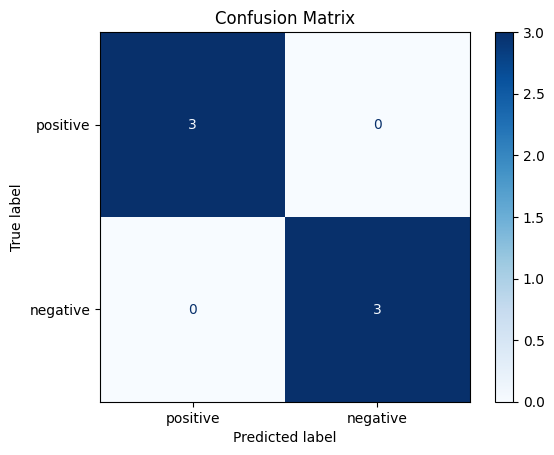

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(df["label"], df["predicted"], labels=["positive", "negative"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["positive", "negative"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


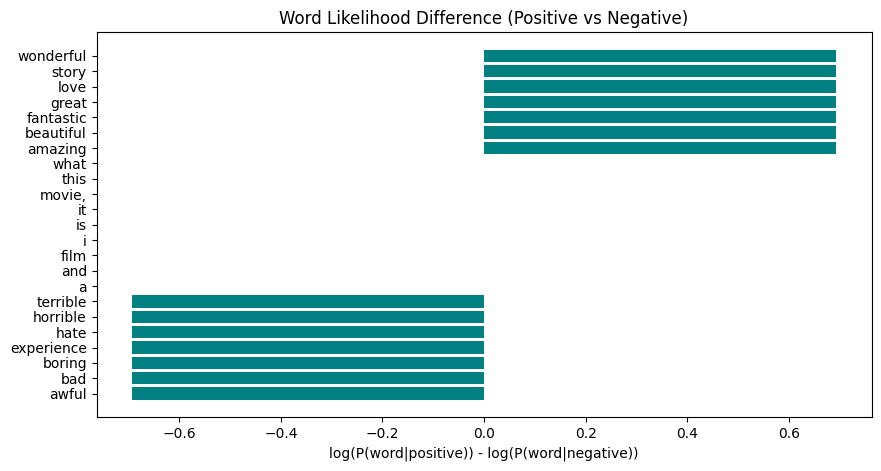

In [20]:
# Sort words by difference in P(word|class)
word_diff = {
    w: np.log(likelihoods["positive"][w]) - np.log(likelihoods["negative"][w])
    for w in vocab
}
sorted_words = sorted(word_diff.items(), key=lambda x: x[1])

plt.figure(figsize=(10, 5))
plt.barh([w for w, _ in sorted_words], [v for _, v in sorted_words], color="teal")
plt.title("Word Likelihood Difference (Positive vs Negative)")
plt.xlabel("log(P(word|positive)) - log(P(word|negative))")
plt.show()


In [79]:
from datasets import load_dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import re

dataset = load_dataset("imdb")

# Convert to pandas and sample for faster computation
train_df = dataset["train"].shuffle(seed=42).select(range(5000)).to_pandas()
test_df = dataset["test"].shuffle(seed=42).select(range(1000)).to_pandas()
train_df.rename(columns={"text": "review", "label": "sentiment"}, inplace=True)
test_df.rename(columns={"text": "review", "label": "sentiment"}, inplace=True)

#  0 -> negative, 1 -> positive
train_df["sentiment"] = train_df["sentiment"].map({0: "negative", 1: "positive"})
test_df["sentiment"] = test_df["sentiment"].map({0: "negative", 1: "positive"})

def clean_and_tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    return text.split()

train_df["tokens"] = train_df["review"].apply(clean_and_tokenize)
test_df["tokens"] = test_df["review"].apply(clean_and_tokenize)

# Build vocabulary from training data
vocab = sorted(set(word for tokens in train_df["tokens"] for word in tokens))
vocab_size = len(vocab)
print("Vocabulary size:", vocab_size)
# Limit to top frequent words
word_freq = Counter(word for tokens in train_df["tokens"] for word in tokens)
vocab = [w for w, _ in word_freq.most_common(5000)]
vocab_size = len(vocab)
print("Reduced vocab size:", vocab_size)

class_docs = defaultdict(list)
for tokens, label in zip(train_df["tokens"], train_df["sentiment"]):
    class_docs[label].append(tokens)

# Compute priors
priors = {c: len(class_docs[c]) / len(train_df) for c in class_docs}

# Count words per class
word_counts = {c: Counter() for c in class_docs}
for c, docs in class_docs.items():
    for doc in docs:
        word_counts[c].update([w for w in doc if w in vocab])

# Compute likelihoods (Laplace smoothing)
likelihoods = {}
for c in class_docs:
    total_count = sum(word_counts[c].values())
    likelihoods[c] = {}
    for w in vocab:
        likelihoods[c][w] = (word_counts[c][w] + 1) / (total_count + vocab_size)

print("Classes:", list(priors.keys()))
print("Example likelihood of 'good':", {c: likelihoods[c].get("good", 0) for c in likelihoods})


Vocabulary size: 50212
Reduced vocab size: 5000
Classes: ['positive', 'negative']
Example likelihood of 'good': {'positive': 0.002784849054347269, 'negative': 0.0027114691624181768}


In [80]:
def predict(tokens):
    scores = {}
    for c in class_docs:
        log_prob = np.log(priors[c])
        for w in tokens:
            if w in vocab:
                log_prob += np.log(likelihoods[c][w])
        scores[c] = log_prob
    return max(scores, key=scores.get)

# Test example
sample = "This movie was fantastic and emotional"
pred = predict(clean_and_tokenize(sample))
print(f"'{sample}' → {pred}")


'This movie was fantastic and emotional' → positive


In [81]:
test_df["predicted"] = test_df["tokens"].apply(predict)
accuracy = np.mean(test_df["predicted"] == test_df["sentiment"])
print(f"Accuracy: {accuracy:.3f}")


Accuracy: 0.803


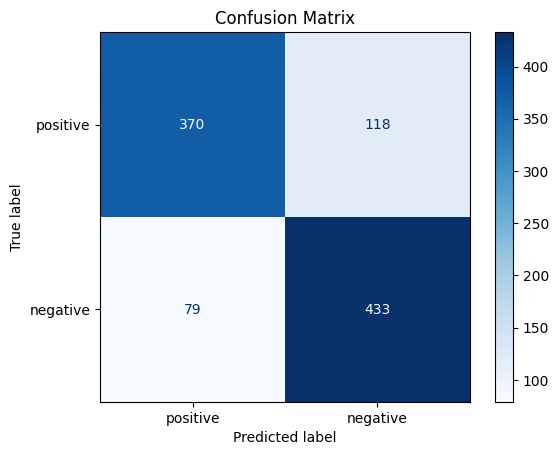

In [82]:
# confusion_matrix
cm = confusion_matrix(test_df["sentiment"], test_df["predicted"], labels=["positive", "negative"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["positive", "negative"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


In [88]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import re

dataset = load_dataset("imdb")

train_data = dataset["train"].shuffle(seed=42).select(range(5000))
test_data = dataset["test"].shuffle(seed=42).select(range(2000))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    return text.split()

# Tokenize
train_tokens = [clean_text(x) for x in train_data["text"]]
test_tokens = [clean_text(x) for x in test_data["text"]]

# Build vocabulary (top 10k words)
from collections import Counter
word_freq = Counter(word for doc in train_tokens for word in doc)
vocab = [w for w, _ in word_freq.most_common(10000)]
word2idx = {w: i + 1 for i, w in enumerate(vocab)}  # 0 for padding
vocab_size = len(vocab) + 1
vocab_size
class IMDBDataset(Dataset):
    def __init__(self, tokens, labels, word2idx, max_len=200):
        self.tokens = tokens
        self.labels = labels
        self.word2idx = word2idx
        self.max_len = max_len

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, idx):
        token_ids = [self.word2idx.get(w, 0) for w in self.tokens[idx][: self.max_len]]
        padding = [0] * (self.max_len - len(token_ids))
        token_ids += padding
        label = 1 if self.labels[idx] == 1 else 0
        return torch.tensor(token_ids), torch.tensor(label)
    
train_dataset = IMDBDataset(train_tokens, train_data["label"], word2idx)
test_dataset = IMDBDataset(test_tokens, test_data["label"], word2idx)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [72]:
class SimpleNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=50):
        super(SimpleNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.fc1 = nn.Linear(embed_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embeds = self.embedding(x)
        avg_embeds = embeds.mean(dim=1)
        out = self.fc1(avg_embeds)
        return self.sigmoid(out).squeeze()
    
model = SimpleNN(vocab_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Training loop
for epoch in range(8):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1, Loss: 0.6870
Epoch 2, Loss: 0.6694
Epoch 3, Loss: 0.6350
Epoch 4, Loss: 0.5861
Epoch 5, Loss: 0.5294
Epoch 6, Loss: 0.4749
Epoch 7, Loss: 0.4271
Epoch 8, Loss: 0.3848


In [73]:
# Evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        preds = (outputs >= 0.5).long()
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())
accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"Test Accuracy: {accuracy:.3f}")


Test Accuracy: 0.815


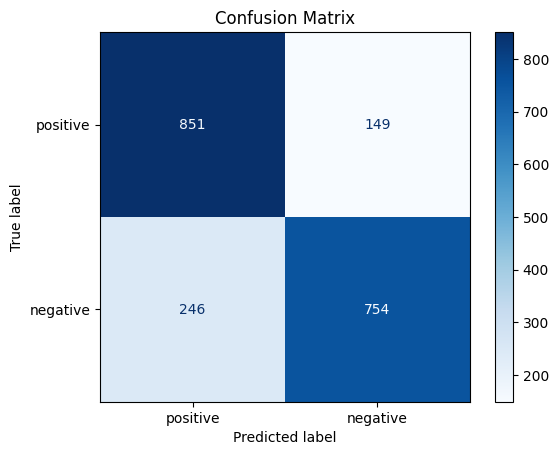

In [42]:
# confusion_matrix
cm = confusion_matrix(all_labels, all_preds, labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["positive", "negative"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


In [117]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import re
from collections import Counter

In [126]:
dataset = load_dataset("imdb")

train_data = dataset["train"].shuffle(seed=42).select(range(10000))
test_data = dataset["test"].shuffle(seed=42).select(range(2000))

In [128]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    return text.split()

train_tokens = [clean_text(x) for x in train_data["text"]]
test_tokens = [clean_text(x) for x in test_data["text"]]

# Build vocab (top 10k words)
word_freq = Counter(word for doc in train_tokens for word in doc)
vocab = [w for w, _ in word_freq.most_common(10000)]
word2idx = {w: i + 1 for i, w in enumerate(vocab)}  # +1 because 0 is for padding
vocab_size = len(word2idx) + 1
print("Vocabulary size:", vocab_size)


Vocabulary size: 10001


In [129]:
embedding_dim = 100
glove_path = "data/glove.6B.100d.txt"
embeddings_index = {}
with open(glove_path, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = vector

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word2idx.items():
    if word in embeddings_index:
        try:
            embedding_matrix[i] = embeddings_index[word]
        except Exception as e:
            print(f"Error loading embedding for {word}: {e}")   
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)
embedding_matrix.shape


torch.Size([10001, 100])

In [130]:
def encode(tokens, max_len=200):
    indices = [word2idx.get(w, 0) for w in tokens][:max_len]
    return indices + [0] * (max_len - len(indices))

X_train = torch.tensor([encode(t) for t in train_tokens])
y_train = torch.tensor(train_data["label"])
X_test = torch.tensor([encode(t) for t in test_tokens])
y_test = torch.tensor(test_data["label"])

class IMDBDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(IMDBDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(IMDBDataset(X_test, y_test), batch_size=64)


In [144]:
class SentimentNN_GloVe(nn.Module):
    def __init__(self, embedding_matrix):
        super().__init__()
        vocab_size, embed_dim = embedding_matrix.shape
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.embedding.weight = nn.Parameter(embedding_matrix)
        self.embedding.weight.requires_grad = True  # freeze embeddings

        self.fc1 = nn.Linear(embed_dim, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        pooled = embedded.mean(dim=1)
        x = self.relu(self.fc1(pooled))
        x = self.fc2(x)
        return self.sigmoid(x)
model = SentimentNN_GloVe(embedding_matrix)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentNN_GloVe(embedding_matrix).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, test_accuracies = [], []


In [145]:
for epoch in range(5):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))

    # Evaluate
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = (model(X_batch) > 0.5).squeeze().cpu()
            correct += (preds == y_batch).sum().item()
            total += len(y_batch)
    acc = correct / total
    test_accuracies.append(acc)
    print(f"Epoch {epoch+1} | Loss: {train_losses[-1]:.4f} | Test Acc: {acc:.3f}")
    

Epoch 1 | Loss: 0.5672 | Test Acc: 0.824
Epoch 2 | Loss: 0.2419 | Test Acc: 0.847
Epoch 3 | Loss: 0.1289 | Test Acc: 0.847
Epoch 4 | Loss: 0.0860 | Test Acc: 0.846
Epoch 5 | Loss: 0.0646 | Test Acc: 0.843
